In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel
tx_power = 2
print('M:',M,'\t','n:',n_channel)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

M: 16 	 n: 1


In [4]:
#generating data of size N
N = 16000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(16000, 16)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
# Average Power Normalization
def fixed_power_norm(x):
    P_avg = 0.04
    beta = K.sqrt(K.sum(K.square(x)))
    return x / beta

In [9]:
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)
encoded3 = Lambda(lambda x: tx_power/np.sqrt(2)*K.l2_normalize(x,axis=-1))(encoded2)

# Gaussian Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel1 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

# Reciever Layer
decoded = Dense(M, activation='relu')(channel1)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
sgd = SGD(lr=0.02)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

W0718 12:59:58.382695 140555158988608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 12:59:58.383541 140555158988608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 12:59:58.386196 140555158988608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 12:59:58.464284 140555158988608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 12:59:58.490715 

In [10]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
__________

In [11]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=1024)

W0718 12:59:58.631593 140555158988608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
16000/16000 [==============================] - 1s 78us/step - loss: 2.4376
Epoch 2/50
16000/16000 [==============================] - 0s 4us/step - loss: 1.8235
Epoch 3/50
16000/16000 [==============================] - 0s 4us/step - loss: 1.4144
Epoch 4/50
16000/16000 [==============================] - 0s 4us/step - loss: 1.1208
Epoch 5/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.9124
Epoch 6/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.7711
Epoch 7/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.6736
Epoch 8/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.5989
Epoch 9/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.5381
Epoch 10/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.4965
Epoch 11/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.4600
Epoch 12/50
16000/16000 [==============================] - 0s 

In [12]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

In [13]:
# making channel from full autoencoder
channel_input = Input(shape=(2*n_channel,))

chan = autoencoder.layers[-3](channel_input)
channel_layer = Model(channel_input,chan)

In [14]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [15]:
# generating data for checking BER
N = 100000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [16]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = 1.5/2*np.array(scatter_plot)
print (scatter_plot.shape)

(16, 1, 2)


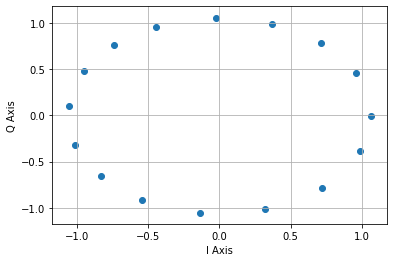

In [17]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

In [18]:
# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(0,20+1,2))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std*np.random.randn(nn,2*n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal+noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: 0 BER: 0.45201
SNR: 2 BER: 0.35282
SNR: 4 BER: 0.24923
SNR: 6 BER: 0.16253
SNR: 8 BER: 0.09706
SNR: 10 BER: 0.05061
SNR: 12 BER: 0.02182
SNR: 14 BER: 0.00742
SNR: 16 BER: 0.00177
SNR: 18 BER: 0.00023
SNR: 20 BER: 0.0


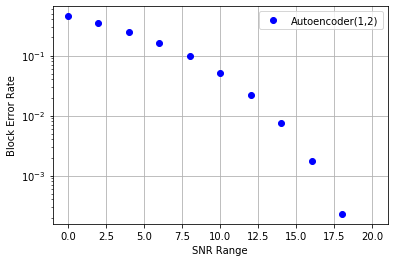

In [19]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(1,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()